In [1]:
#basic
import pandas as pd
import numpy as np
import re


#visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#warning
import warnings
warnings.filterwarnings('ignore')

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#scikit-learn labs
from sklearn.metrics import confusion_matrix, classification_report,auc,fbeta_score,f1_score,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV,train_test_split as split,learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Data Loading and cleaning

In [2]:
df=pd.read_csv('digital_marketing_campaign_dataset.csv')

#clean the columns
df.rename(lambda col: col.lower(),axis=1,inplace=True)
df.rename(lambda col: col.strip(),axis=1,inplace=True)

# add underscore to each column i choose convinevincy
df.rename(columns={'campaignchannel':'campaign_channel',
         'campaigntype':'campaign_type',
         'adspend':'ad_spend',
         'clickthroughrate':'click_throughrate',
         'conversionrate':'conversion_rate',
         'websitevisits':'website_visits',
         'pagespervisit':'pages_per_visit',
         'timeonsite':'time_on_site',
         'socialshares':'social_shares',
         'emailopens':'email_opens',
         'emailclicks':'email_clicks',
         'previouspurchases':'previous_purchases',
         'advertisingplatform':'advertising_platform',
         'advertisingtool':'advertising_tool'},inplace=True)

# drop the caustomer id column and the advertising columns because they present only one option
df.drop(columns=['customerid','advertising_platform','advertising_tool'],axis=1,inplace=True)

df.head()

,age,gender,income,campaign_channel,campaign_type,ad_spend,click_throughrate,conversion_rate,website_visits,pages_per_visit,time_on_site,social_shares,email_opens,email_clicks,previous_purchases,loyaltypoints,conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


In [115]:
def present_df(df):    
    print(f'{df.shape}')
    table=pd.DataFrame(df.dtypes,columns=['type']).reset_index().rename(columns={'index':'features'})
    table['%_nulls']=df.isnull().sum().values/len(df)
    table['#_uniques']=df.nunique().values
    table['%_uniques']=df.nunique().values/len(df)
    
    return table.set_index('features')

present_df(df)

(8000, 17)


,type,%_nulls,#_uniques,%_uniques
features,,,,
age,int64,0.0,52,0.006500
gender,object,0.0,2,0.000250
income,int64,0.0,7789,0.973625
campaign_channel,object,0.0,5,0.000625
campaign_type,object,0.0,4,0.000500
ad_spend,float64,0.0,8000,1.000000
click_throughrate,float64,0.0,8000,1.000000
conversion_rate,float64,0.0,8000,1.000000
website_visits,int64,0.0,50,0.006250


# Hypothesis
H0: there isn't a conversion at the end of the marketing process ->> False

H1: there is a conversion at the end of the marketing process ->> True


# EDA

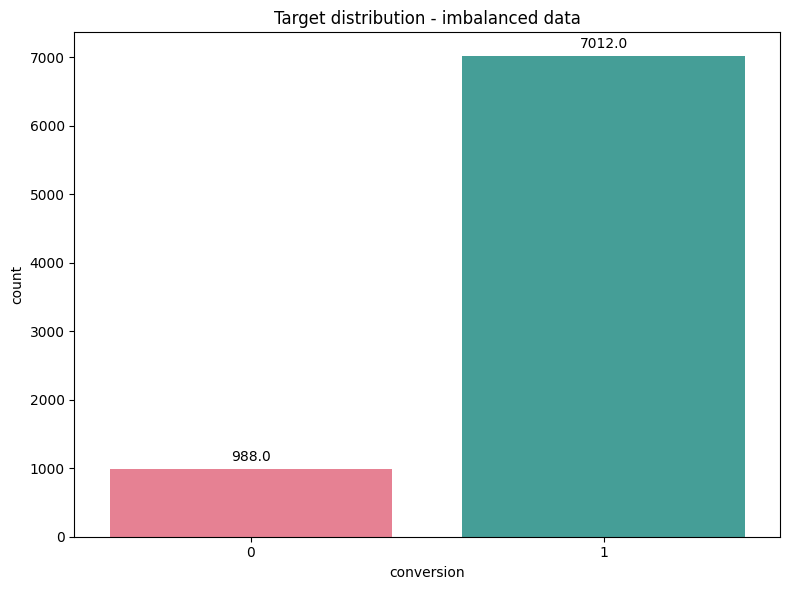

In [5]:
plt.figure(figsize=(8,6),dpi=100)
plt.title('Target distribution - imbalanced data')
ax=sns.countplot(data=df,x='conversion', palette='husl')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [6]:
# definiation of numeric df columns
numeric_cols=df.select_dtypes("number").drop(columns=['conversion'])
# VIF dataframe
vif=pd.DataFrame()
vif["feature"] = numeric_cols.columns

# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(numeric_cols.values, i)
                          for i in range(len(numeric_cols.columns))]

print(f"VIF score under 5 is ok, over 10 means multicollinearity suspicious\n{vif.sort_values(by='VIF', ascending=False)}")

# score formula ->> 1/1-r^2

VIF score under 5 is ok, over 10 means multicollinearity suspicious
               feature       VIF
0                  age  7.995081
1               income  5.508206
6      pages_per_visit  5.020859
4      conversion_rate  4.319049
3    click_throughrate  4.063372
7         time_on_site  4.042749
2             ad_spend  3.831666
12       loyaltypoints  3.779374
5       website_visits  3.731451
8        social_shares  3.704925
9          email_opens  3.561025
10        email_clicks  3.288609
11  previous_purchases  3.228477


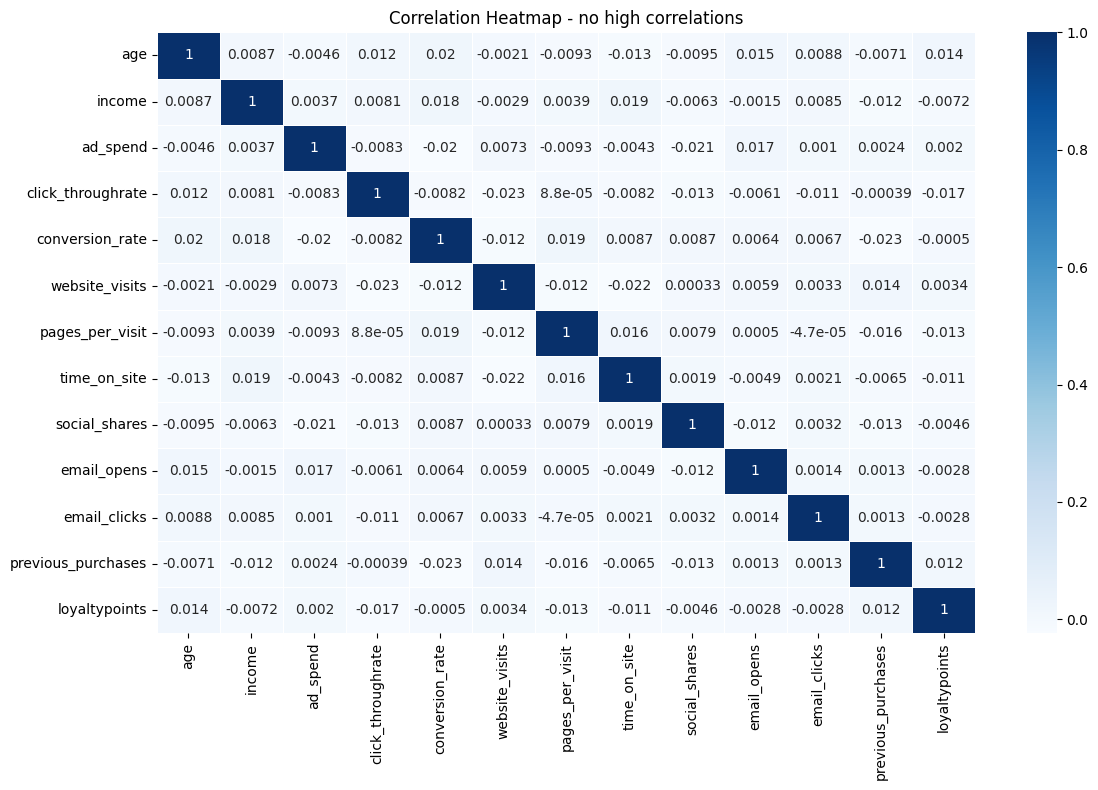

In [51]:
plt.figure(figsize=(12,8),dpi=100)
sns.heatmap(data=df.select_dtypes('number').drop(columns=['conversion'],axis=1).corr(),annot=True,linewidths=0.5,cmap='Blues')
plt.title("Correlation Heatmap - no high correlations")

plt.tight_layout()
plt.show()

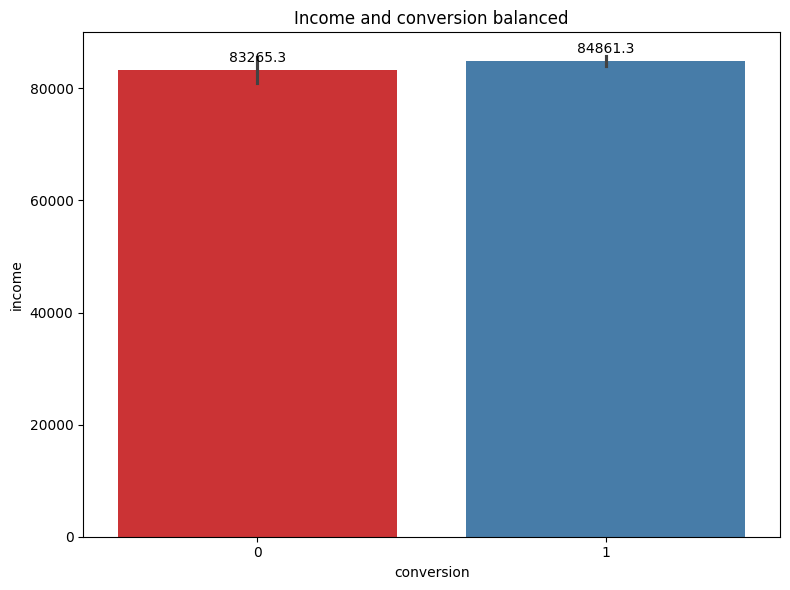

In [11]:
plt.figure(figsize=(8,6),dpi=100)
plt.title('Income and conversion balanced')
ax=sns.barplot(data=df,x='conversion',y='income', palette='Set1')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [3]:
# changing the gender column type to save extra columns later on the one hot encoding section
df['gender']=df['gender'].map({'Female':0,'Male':1})

In [22]:
df.head()

,age,gender,income,campaign_channel,campaign_type,ad_spend,click_throughrate,conversion_rate,website_visits,pages_per_visit,time_on_site,social_shares,email_opens,email_clicks,previous_purchases,loyaltypoints,conversion
0,56,0,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,1,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,0,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,0,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,0,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


# PreProcessing

In [4]:
x=df.drop(columns=['conversion','age'],axis=1)
y=df['conversion']

X_train,X_test,y_train,y_test=split(x,y,shuffle=True,test_size=0.25,random_state=42)

In [11]:
class myOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        super().__init__()
        self.ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')


    def fit(self,X,y=None):
        self.ohe.fit(X.select_dtypes(['object']))
        return self


    def transform(self,X):
        X_rest=pd.DataFrame(self.ohe.transform(X.select_dtypes(['object'])))
        X_numeric=X.select_dtypes('number')

        output=np.concatenate([X_rest,X_numeric],axis=1)

        return output
    
    
    def get_features_name(self):
        return self.ohe

In [6]:
# create a pipline
my_pipe=Pipeline(steps=[('ohe',myOneHotEncoder()),('scaler',MinMaxScaler())])

X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.transform(X_test)

# Model

### Logistic Regression

In [96]:
def lr_weights_optimizer(X_train,y_train,X_test,y_test):
    """class_weight plot do like an elbow method to find the optimization"""
    weights_list=[]
    for i in np.linspace(0,1,25):
        lr=LogisticRegression(random_state=42, solver='liblinear',class_weight={0:1-i,1:i})
        
        lr.fit(X_train,y_train)
        y_pred=lr.predict(X_test)
        
        score=f1_score(y_test,y_pred)
        weights_list.append(score)
        
    return weights_list
    

weight_score_list=lr_weights_optimizer(X_train_model,y_train,X_test_model,y_test)

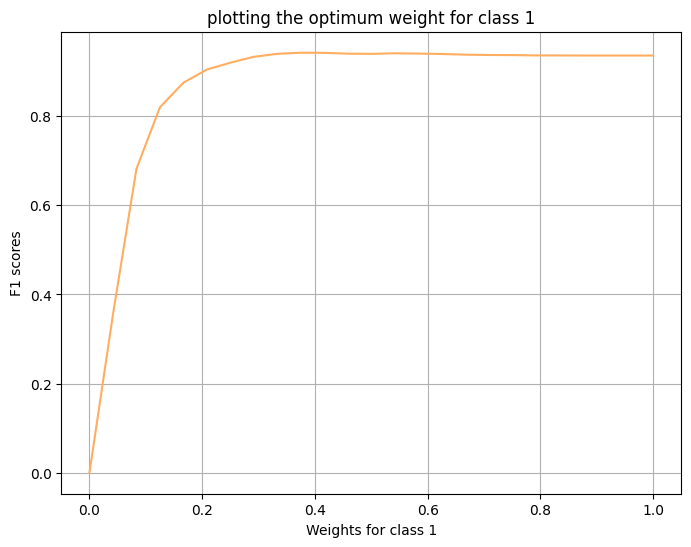

In [12]:
plt.figure(figsize=(8,6),dpi=100)
sns.lineplot(x=np.linspace(0,1,25),y=weight_score_list,color='#FFAD60')
plt.title('plotting the optimum weight for class 1')
plt.xlabel('Weights for class 1')
plt.ylabel('F1 scores')
plt.grid()
plt.show()

In [147]:
lr=LogisticRegression(random_state=42, solver='liblinear',class_weight={0:0.7,1:0.3})

# both hyperparameter are trying to find the right combination of regularization
c=np.linspace(0,1,20)
l1_ratio=np.linspace(0,1,20)

lr_params={'C':c,'l1_ratio':l1_ratio}

log_model=GridSearchCV(lr,lr_params,scoring='f1',cv=4)

In [148]:
log_model.fit(X_train_model,y_train)

GridSearchCV(cv=4,
             estimator=LogisticRegression(class_weight={0: 0.7, 1: 0.3},
                                          random_state=42, solver='liblinear'),
             param_grid={'C': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='f1')

In [149]:
log_model.best_params_

{'C': np.float64(0.3684210526315789), 'l1_ratio': np.float64(0.0)}

In [150]:
y_pred=log_model.predict(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.57      0.38      0.45       241
           1       0.92      0.96      0.94      1759

    accuracy                           0.89      2000
   macro avg       0.74      0.67      0.70      2000
weighted avg       0.88      0.89      0.88      2000



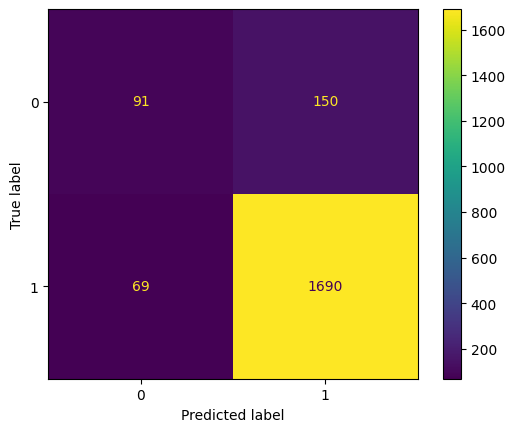

In [151]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_model.classes_)
disp.plot()
plt.show()

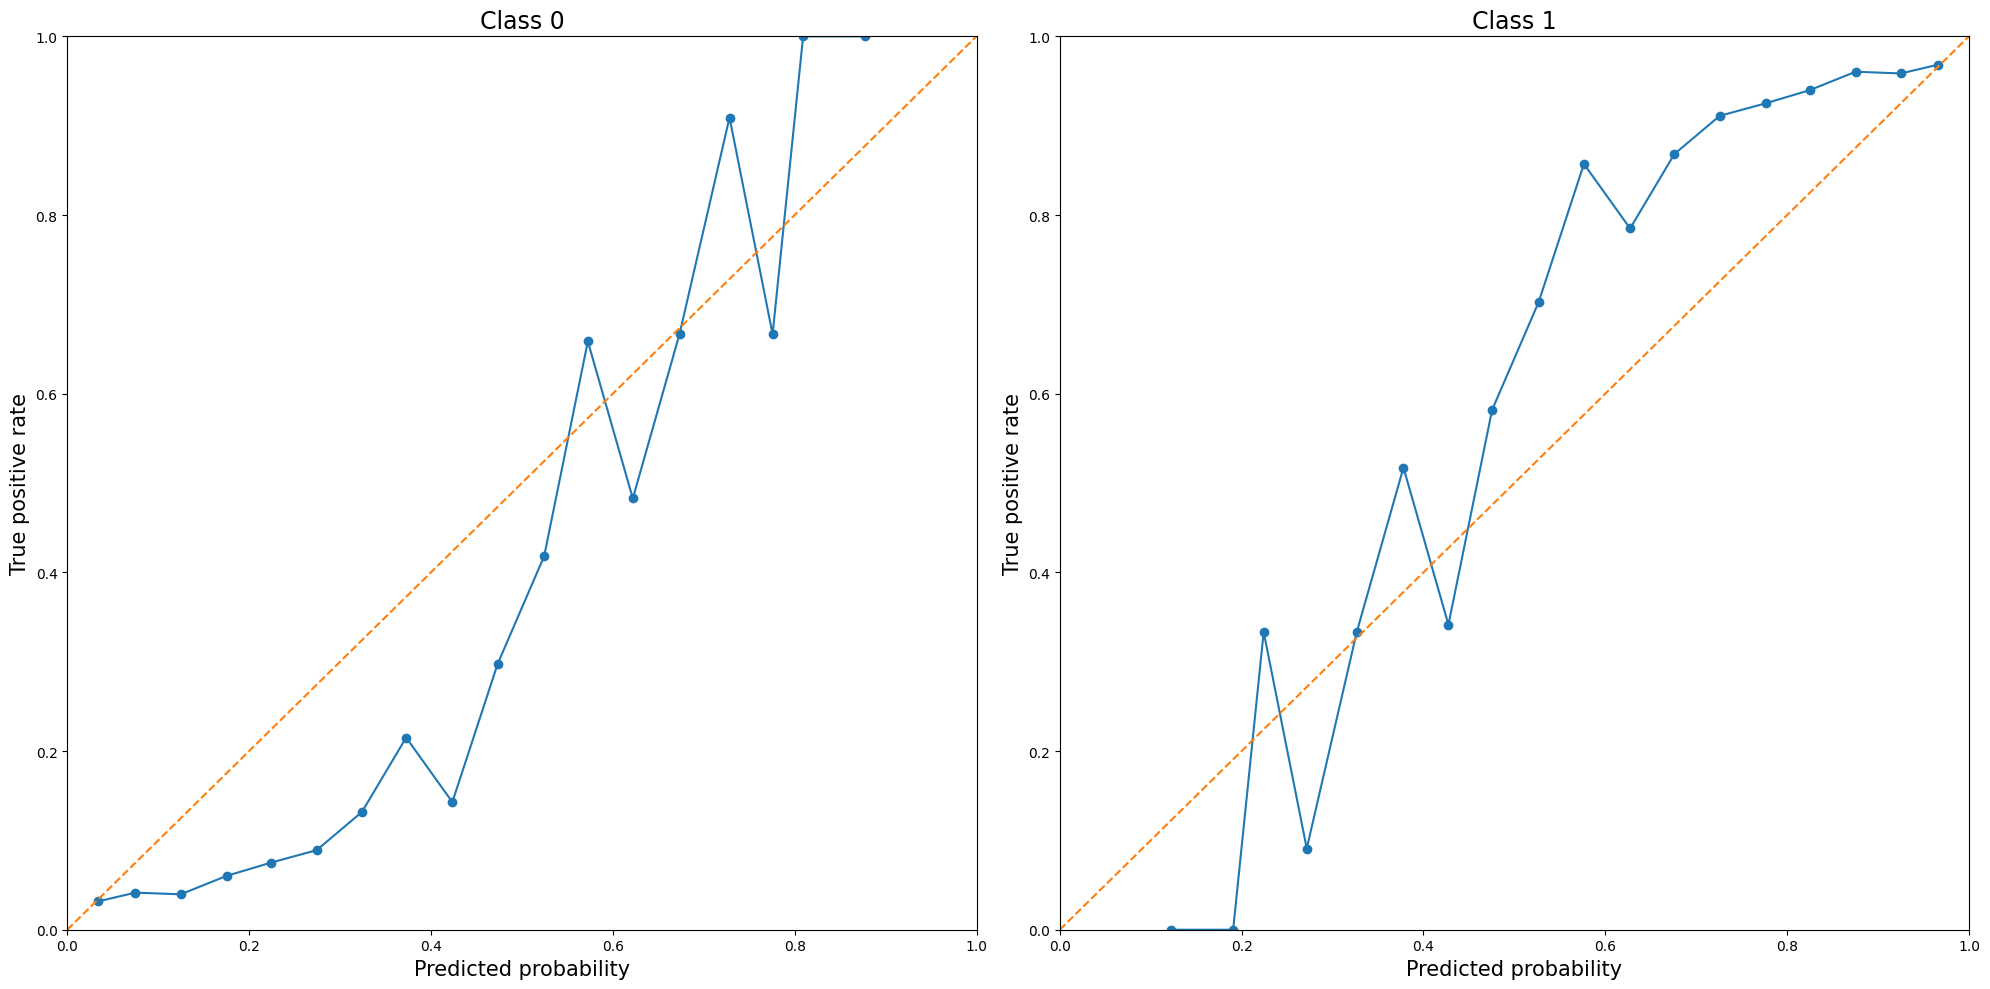

In [18]:
from sklearn.calibration import calibration_curve


num_of_classes=len(log_model.predict_proba(X_test_model)[0])
probabilities=log_model.predict_proba(X_test_model)

# Compute the calibration curve for each class
calibration_curve_values = []
for i in range(num_of_classes):
    curve = calibration_curve(y_test == i,probabilities[:, i],n_bins=20,pos_label=True)
    calibration_curve_values.append(curve)

# Plot the calibration curves
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

for i in range(num_of_classes):
    axs[i].plot(calibration_curve_values[i][1],
                calibration_curve_values[i][0],
                marker='o')
    axs[i].plot([0, 1], [0, 1], linestyle='--')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_title(f"Class {i}", fontsize=17)
    axs[i].set_xlabel("Predicted probability", fontsize=15)
    axs[i].set_ylabel("True positive rate", fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
# a metric used to measure the accuracy of probabilistic predictions.
# Formula: BS = (1/N) * Σ(f - o)², where f is the predicted probability, o is the actual outcome (0 or 1),
# and N is the number of predictions.

from sklearn.metrics import brier_score_loss
y_pred_proba=log_model.predict_proba(X_test_model)[:,0]
brier_score = brier_score_loss(y_test, y_pred_proba)
brier_score

np.float64(0.09941935794972889)

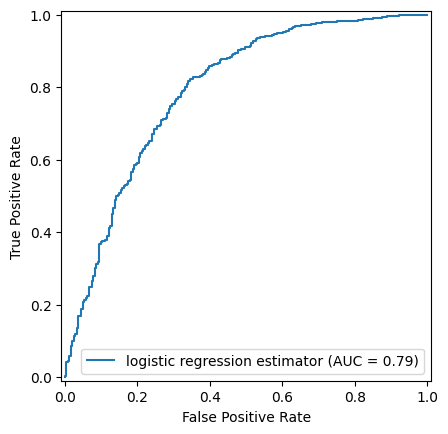

In [106]:
fpr, tpr, thresholds=roc_curve(y_true=y_test,y_score=y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='logistic regression estimator')
display.plot()  
plt.show()  

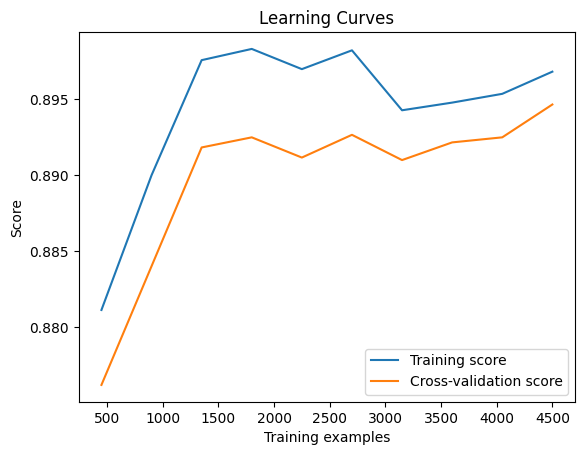

In [152]:
train_sizes, train_scores, val_scores = learning_curve(
    log_model, X_train_model, y_train, cv=4, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

### SVM

In [7]:
def svm_weights_optimizer(X_train,y_train,X_test,y_test):
    """class_weight plot do like an elbow method to find the optimization"""
    weights_list=[]
    for i in np.linspace(0.05,0.95,25):
        svm=SVC(class_weight={0:1-i,1:i},random_state=42)
        
        try:
            svm.fit(X_train,y_train)
            y_pred=svm.predict(X_test)

            score=f1_score(y_test,y_pred)
            weights_list.append(score)
        
        except Exception as e:
            print(f"Error at weight {i}: {str(e)}")
            weights_list.append(None)
        
    return weights_list
    

svm_weight_score_list=svm_weights_optimizer(X_train_model,y_train,X_test_model,y_test)

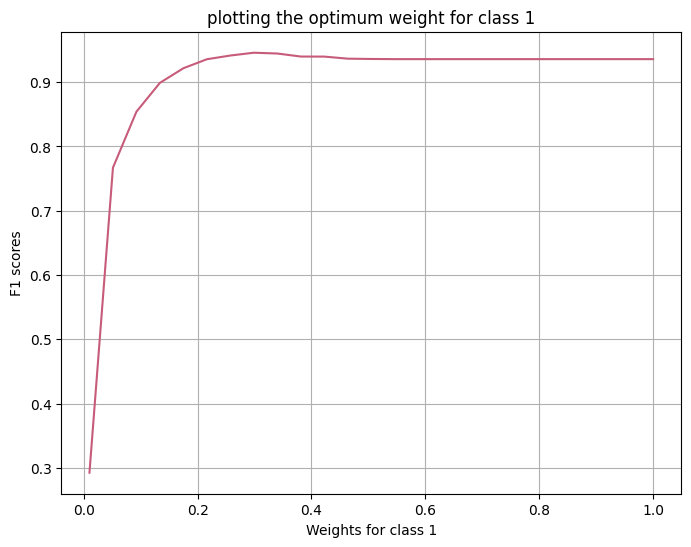

In [8]:
plt.figure(figsize=(8,6),dpi=100)
sns.lineplot(x=np.linspace(0.01,1,25),y=svm_weight_score_list,color='#C75B7A')
plt.title('plotting the optimum weight for class 1')
plt.xlabel('Weights for class 1')
plt.ylabel('F1 scores')
plt.grid()
plt.show()

In [9]:
svm=SVC(class_weight={0:0.75,1:0.25},random_state=42)

gamma=['scale', 'auto']
c=np.linspace(-5,5,50)
kernel=['linear', 'poly', 'rbf']

svm_params={'C':c,'gamma':gamma,'kernel':kernel}
svm_model=GridSearchCV(svm,svm_params,scoring='f1',cv=4)

In [10]:
svm_model.fit(X_train_model,y_train)

GridSearchCV(cv=4,
             estimator=SVC(class_weight={0: 0.75, 1: 0.25}, random_state=42),
             param_grid={'C': array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
       -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
       -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
       -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
       -0.91836735, -0.7142...0.10204082,
        0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
        1.12244898,  1.32653061,  1.53061224,  1.73469388,  1.93877551,
        2.14285714,  2.34693878,  2.55102041,  2.75510204,  2.95918367,
        3.16326531,  3.36734694,  3.57142857,  3.7755102 ,  3.97959184,
        4.18367347,  4.3877551 ,  4.59183673,  4.79591837,  5.        ]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1')

In [11]:
svm_model.best_params_

{'C': np.float64(0.9183673469387754), 'gamma': 'auto', 'kernel': 'rbf'}

In [16]:
y_pred=svm_model.predict(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48       241
           1       0.92      0.96      0.94      1759

    accuracy                           0.89      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.88      0.89      0.88      2000



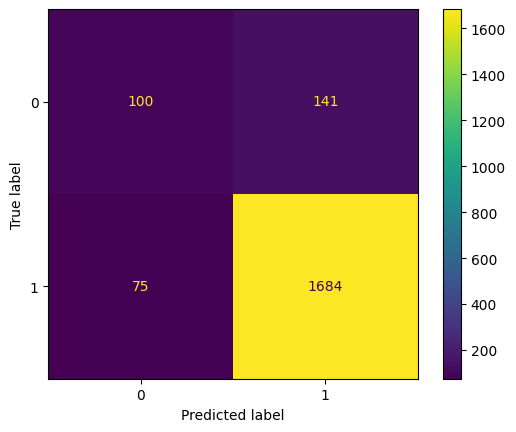

In [13]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_model.classes_)
disp.plot()
plt.show()

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    svm_model, X_train_model, y_train, cv=4, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

In [108]:
from svm_margin_plotly import plot_svm_boundary

plot_svm_boundary(svm_model,X_train_model,y_train)

### SMOTE

In [121]:
from imblearn.over_sampling import SMOTE
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
smote = SMOTE(random_state=42,sampling_strategy={0:2500,1:5253} )
X_train_smoted, y_train= smote.fit_resample(X_train_model, y_train)

y_train.value_counts()

conversion
1    5253
0    2500
Name: count, dtype: int64

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=42,n_estimators=150)

criterion=['gini','entropy']
max_depth=[3,5,7,10]
max_features=['sqrt','log2']
min_samples_split=[2,5,7]
max_samples=[0.25,0.5]
min_impurity_decrease=[0.0,0.1,0.2]

tree_params={'criterion':criterion,
             'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_samples_split,
            'max_samples':max_samples,
            'min_impurity_decrease':min_impurity_decrease}

tree_grid=GridSearchCV(rf,tree_params,scoring='f1',cv=4)

In [122]:
from sklearn.ensemble import RandomForestClassifier

rf_best_params=RandomForestClassifier(random_state=42,criterion='gini',max_depth=10,max_features='sqrt',max_samples=0.5,
                                    min_impurity_decrease=0.0,min_samples_split=5 )

n_estimators=[100,200]
tree_params={'n_estimators':n_estimators}

tree_grid=GridSearchCV(rf_best_params,tree_params,scoring='f1',cv=4)

In [123]:
tree_grid.fit(X_train_smoted,y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=10, max_samples=0.5,
                                              min_samples_split=5,
                                              random_state=42),
             param_grid={'n_estimators': [100, 200]}, scoring='f1')

In [69]:
tree_grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_impurity_decrease': 0.0,
 'min_samples_split': 5}

In [124]:
y_pred=svm_model.predict(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48       241
           1       0.92      0.96      0.94      1759

    accuracy                           0.89      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.88      0.89      0.88      2000



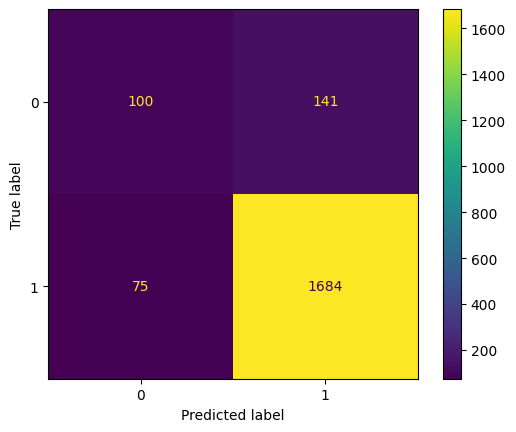

In [125]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_model.classes_)
disp.plot()
plt.show()

In [86]:
from sklearn.metrics import accuracy_score, f1_score

train_accuracy = accuracy_score(y_train, tree_grid.predict(X_train_smoted))
test_accuracy = accuracy_score(y_test, tree_grid.predict(X_test_model))

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9260931252418418
Test Accuracy: 0.9015


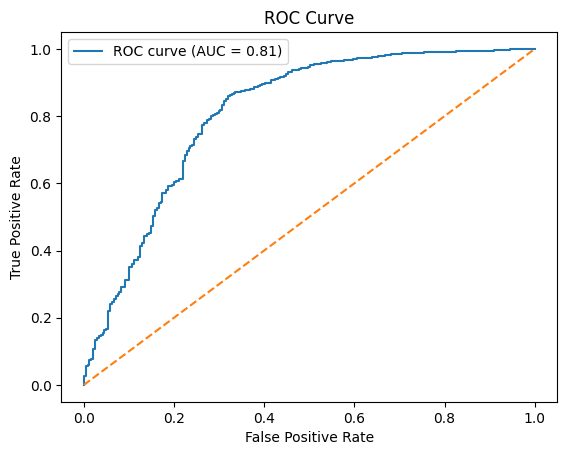

In [126]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, tree_grid.predict_proba(X_test_model)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

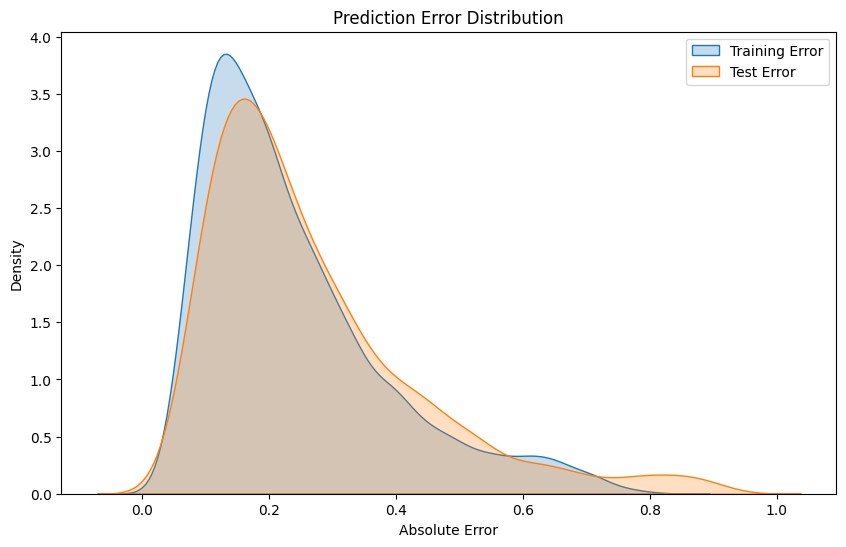

Training Error: Mean = 0.2401, Std = 0.1466
Test Error: Mean = 0.2684, Std = 0.1685


In [128]:
def plot_prediction_error_distribution(model, X_train, y_train, X_test, y_test):
    # For classification, we'll use probability predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate errors
    train_errors = np.abs(train_probs - y_train)
    test_errors = np.abs(test_probs - y_test)
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_errors, shade=True, label='Training Error')
    sns.kdeplot(test_errors, shade=True, label='Test Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Density')
    plt.title('Prediction Error Distribution')
    plt.legend()
    plt.show()
    
    # Print some statistics
    print(f"Training Error: Mean = {train_errors.mean():.4f}, Std = {train_errors.std():.4f}")
    print(f"Test Error: Mean = {test_errors.mean():.4f}, Std = {test_errors.std():.4f}")

# Usage
plot_prediction_error_distribution(tree_grid, X_train_smoted, y_train, X_test_model, y_test)

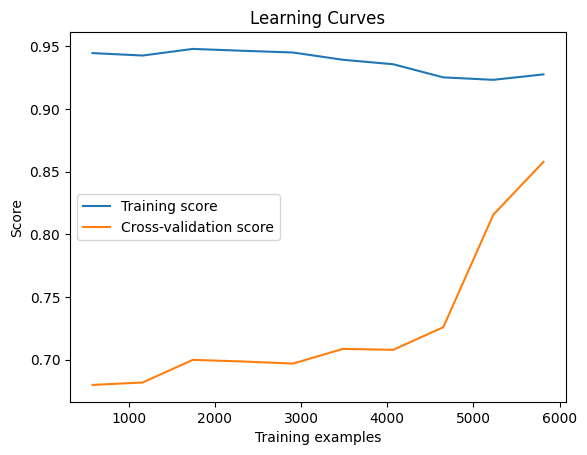

In [144]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    tree_grid, X_train_smoted, y_train, cv=4, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

# Conclusion

Although the 3 models scores quite the same for this data, the 3rd model includes random forest and data oversampling with smote is overfitting the data.
